In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'european_starling_gentner_segmented'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [7]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=1,
    mel_upper_edge_hertz=1995,
    butter_lowcut = 1,
    butter_highcut = 1995,
    ref_level_db = 20,
    min_level_db = -25,
    win_length_ms = 100,
    hop_length_ms = 20,
    mask_spec = True,
    mask_spec_kwargs = {"spec_thresh": 0.25, "offset": 1e-10},
    reduce_noise=True,
    noise_reduce_kwargs = {"n_std_thresh": 1.5, "prop_decrease":0.9}

)

In [8]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.0min


[Parallel(n_jobs=-1)]: Done 3805 out of 3805 | elapsed:  2.0min finished


In [9]:
dataset.sample_json

OrderedDict([('species', 'Lonchura striata domestica'),
             ('common_name', 'Sturnus vulgaris'),
             ('indvs',
              OrderedDict([('b1077',
                            OrderedDict([('syllables',
                                          OrderedDict([('start_times',
                                                        [16.338]),
                                                       ('end_times',
                                                        [16.509])]))]))])),
             ('datetime', '2017-12-18_10-39-28'),
             ('samplerate_hz', 44100),
             ('length_s', 26.09),
             ('wav_loc',
              '/mnt/cube/Datasets/starling_zenodo/b1077/wavs/2017-12-18_10-39-28-170000.wav')])

In [100]:
### parameters
n_fft=512
hop_length_ms=4
win_length_ms=10
ref_level_db=20
pre=0.97
min_level_db=-70
min_level_db_floor = -20
silence_threshold = 0.1
min_silence_for_spec=0.1
max_vocal_for_spec=1.0,
min_syllable_length_s = 0.01
spectral_range = [500, 16000]

In [101]:
# for each wav, compute the spectrogram, break the spectrogram up into multiple segments, then project into PCA, then plot PCA projections over time

In [102]:
indvs = np.array([list(i)[0] for i in dataset.json_indv])
np.unique(indvs)

array(['b1053', 'b1060', 'b1066', 'b1076', 'b1077', 'b1125', 'b1143'],
      dtype='<U5')

In [103]:
indv = 'b1053'

In [104]:
indv_keys = np.array(list(dataset.data_files.keys()))[indvs==indv]

In [105]:
key = indv_keys[5]

In [106]:
for key in indv_keys:
    break

In [107]:
wf = dataset.data_files[key].data['wav_loc']

In [108]:
import librosa
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation

In [109]:
data, rate = librosa.core.load(wf, sr=None)
len(data)/rate

61.89

In [110]:
data = butter_bandpass_filter(data, 500, 15999, rate, order = 2)

In [111]:
results = dynamic_threshold_segmentation(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    ref_level_db=ref_level_db,
    pre=pre,
    min_level_db=min_level_db,
    silence_threshold = silence_threshold,
    verbose=True,
    min_level_db_floor=min_level_db_floor,
    spectral_range = spectral_range,
    min_syllable_length_s = min_syllable_length_s
    
)

/mnt/cube/tsainbur/Projects/github_repos/vocalization_segmentation/vocalseg/dynamic_thresholding.py:129: RuntimeWarning: invalid value encountered in sqrt
  vocal_envelope = np.max(spec, axis=0) * np.sqrt(np.mean(spec, axis=0))


longest silence 6.207999999999998
longest vocalization 1.1959999999999997
Current min_level_db: -70
longest silence 6.207999999999998
longest vocalization 1.2119999999999997
Current min_level_db: -65
longest silence 6.207999999999998
longest vocalization 1.072000000000001
Current min_level_db: -60
longest silence 6.211999999999996
longest vocalization 0.984


In [112]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [113]:
figsize = (50,4)

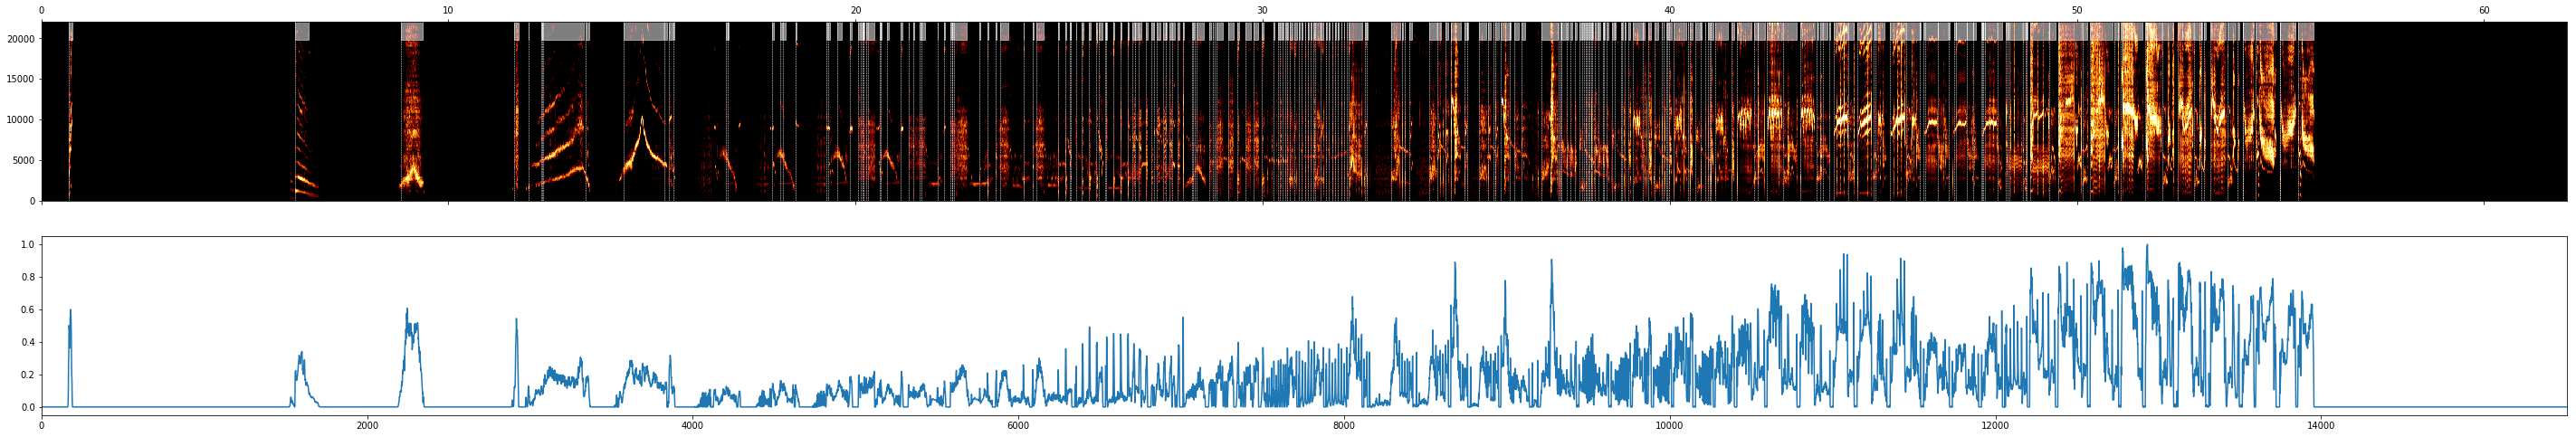

In [114]:
fig, axs = plt.subplots(nrows = 2, figsize=(figsize[0], figsize[1]*2))
plot_spec(results['spec'], fig, axs[0], rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
axs[1].plot(results['vocal_envelope'])
#axs[1].plot(results['vocal_envelope'] > silence_threshold)
axs[1].set_xlim([0, len(results['vocal_envelope'])])

ylmin, ylmax = (axs[0].get_ylim())
ysize = (ylmax - ylmin)*.1
ymin = ylmax- ysize

patches = []
for onset, offset in zip(results['onsets'], results['offsets']):
    axs[0].axvline(onset, color = '#FFFFFF', ls="dashed", lw=0.5)
    patches.append(Rectangle(xy=(onset, ymin), width = offset-onset, height = ysize))

collection = PatchCollection(patches, color='white', alpha=0.5)
axs[0].add_collection(collection);

In [188]:
from itertools import islice

def window(seq, n=2, skip = 100):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [189]:
spec = results['spec']
np.shape(spec)

(181, 15508)

In [190]:
from PIL import Image

In [191]:
spec = np.array(Image.fromarray(spec).resize((np.shape(spec)[1], 32), Image.ANTIALIAS))
np.shape(spec)

(32, 15508)

In [192]:
from avgn.umap import umap_reduce

In [193]:
import seaborn as sns

In [194]:
window_length_frames = int(window_length_ms / hop_length_ms)
window_length_frames

25

In [207]:
UMAP_dict = {}
for window_length_ms in tqdm([20, 100, 250]):
    window_length_frames = int(window_length_ms / hop_length_ms)
    windows = [i for i in window(spec.T, n =window_length_frames)]
    windows = np.reshape(windows, (len(windows), np.product(np.shape(windows)[1:])))
    z, _ = umap_reduce(windows, min_dist = 0.5)
    UMAP_dict[window_length_ms] = z

Exception ignored in: <bound method UMAP.__del__ of UMAP()>
Traceback (most recent call last):
  File "cuml/manifold/umap.pyx", line 313, in cuml.manifold.umap.UMAP.__del__
AttributeError: 'UMAP' object has no attribute 'umap_params'
/local/home/tsainbur/github_repos/avgn_paper/avgn/umap.py:11: UserWarning: Exception occured! file=/conda/conda-bld/libcuml_1566588242169/work/cpp/src/common/cumlHandle.cpp line=177: FAIL: call='cudaGetDevice(&cur_dev)'. Reason:no CUDA-capable device is detected

Obtained 64 stack frames
#0 in /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/cuml/common/../../../../libcuml++.so(_ZN8MLCommon9Exception16collectCallStackEv+0x3e) [0x7f7e1559056e]
#1 in /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/cuml/common/../../../../libcuml++.so(_ZN8MLCommon9ExceptionC2ERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE+0x80) [0x7f7e15591080]
#2 in /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/cuml/common/../../../../lib

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
Exception ignored in: <bound method UMAP.__del__ of UMAP()>
Traceback (most recent call last):
  File "cuml/manifold/umap.pyx", line 313, in cuml.manifold.umap.UMAP.__del__
AttributeError: 'UMAP' object has no attribute 'umap_params'
/local/home/tsainbur/github_repos/avgn_paper/avgn/umap.py:11: UserWarning: Exception occured! file=/conda/conda-bld/libcuml_1566588242169/work/cpp/src/common/cumlHandle.cpp line=177: FAIL: call='cudaG

NameError: name 'FIGURE_DIR' is not defined

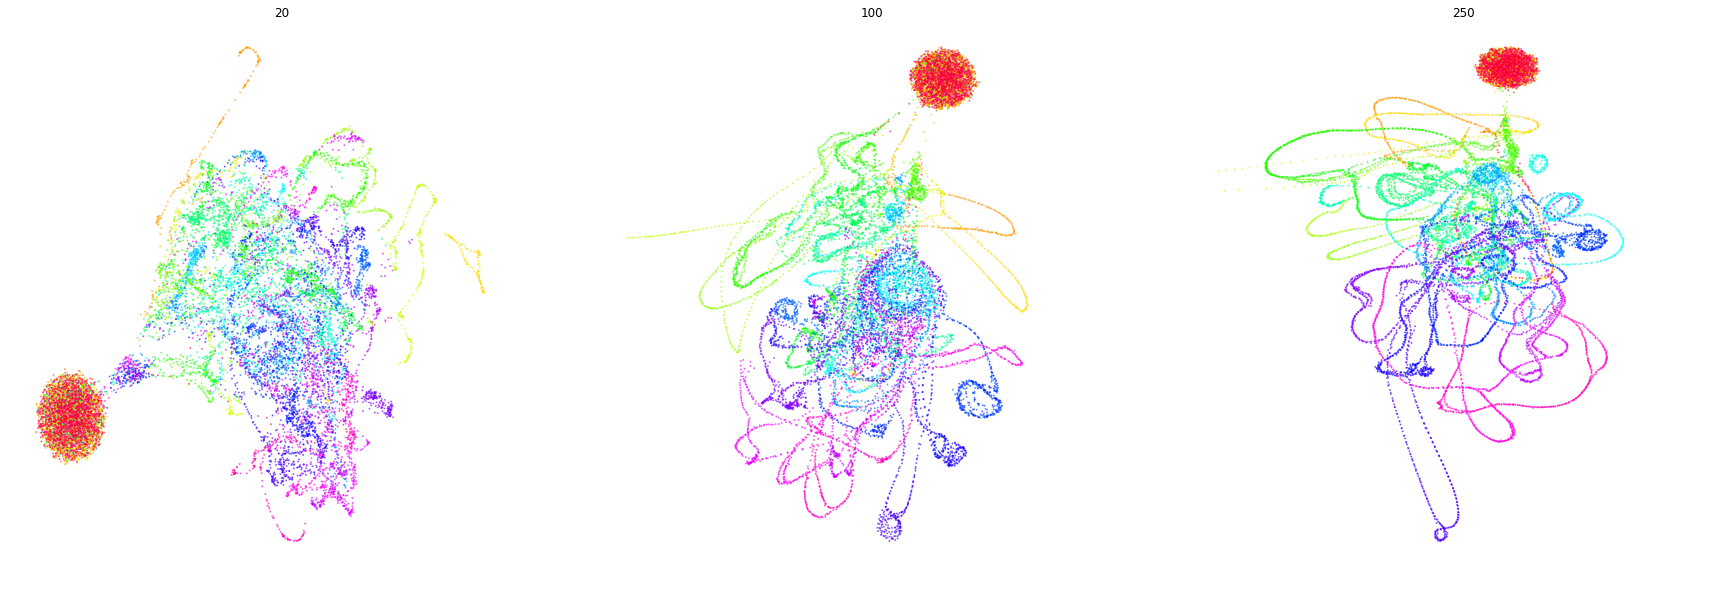

In [217]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))

for axi, window_length_ms in enumerate(UMAP_dict):
    z = UMAP_dict[window_length_ms]
    cols = sns.color_palette('hsv', len(z))
    ax[axi].scatter(z[:,0], z[:,1], alpha = 0.5, s = 1, color=cols)
    ax[axi].set_title(window_length_ms)
    ax[axi].set_xlim([-15,15])
    ax[axi].axis('off')
ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)
save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / 'starling', save_svg=True, save_png=True)

In [209]:
import numpy as np
import pylab as pl
from matplotlib.colors import hsv_to_rgb
from matplotlib import gridspec

In [210]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [211]:
rgb_imgs = []
for axi, window_length_ms in enumerate(UMAP_dict):
    z = UMAP_dict[window_length_ms]
    
    # colormap
    H = norm(z[:,0])
    V = norm(z[:,1])
    S = np.ones_like(V)
    HSV = np.dstack((H,S,V))
    RGB = hsv_to_rgb(HSV)
    RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
    rgb_img = np.expand_dims(RGB,0)
    rgb_imgs.append(rgb_img)

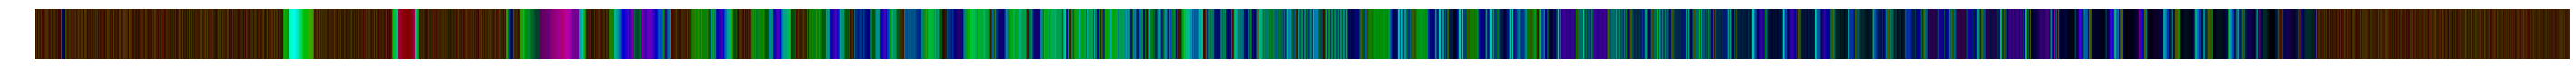

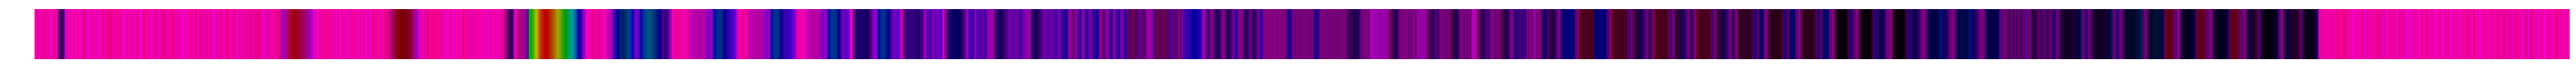

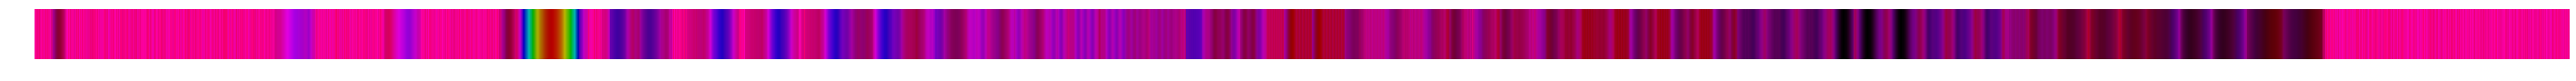

In [212]:
for rgb_img in rgb_imgs:
    fig, ax = plt.subplots(figsize=(50,1))
    ax.imshow(rgb_img, interpolation=None, aspect='auto')
    ax.axis('off')

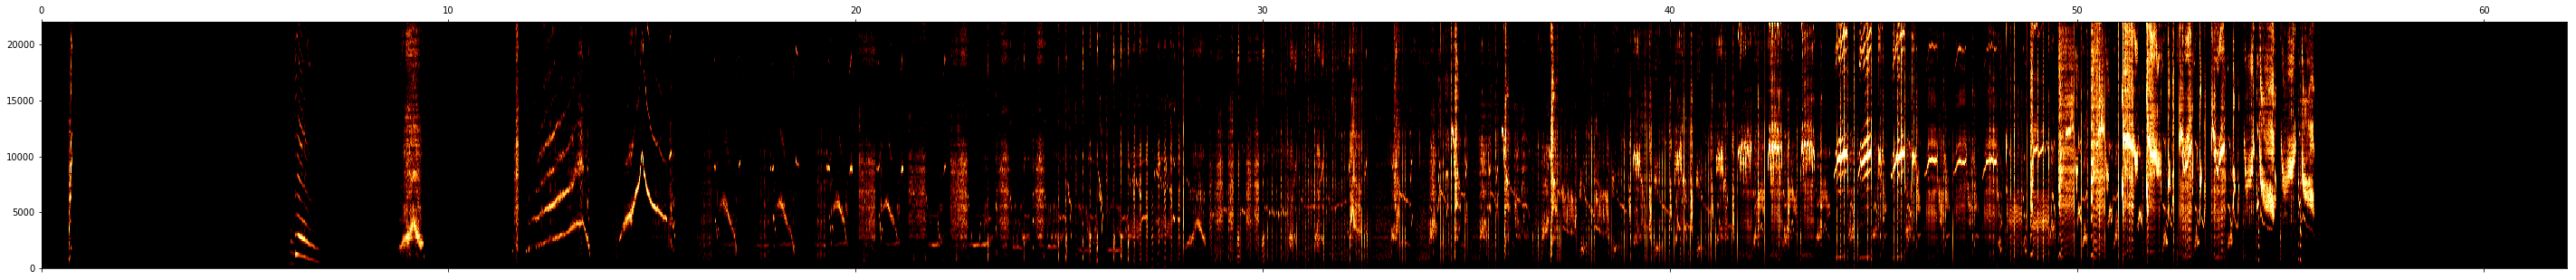

In [213]:
fig, ax = plt.subplots(figsize=(50,5))
plot_spec(results['spec'], fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);

In [ ]:
fig_len = 100

In [ ]:
rgb_imgs = []
for axi, window_length_ms in enumerate(UMAP_dict):
    z = UMAP_dict[window_length_ms]
    
    # colormap
    R = norm(z[:,0])
    G = norm(z[:,1])
    B = np.ones_like(G)/2
    RGB = np.dstack((R,G,B))
    RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
    rgb_img = np.expand_dims(RGB,0)
    rgb_imgs.append(rgb_img)

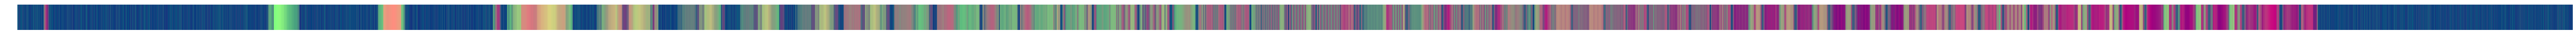

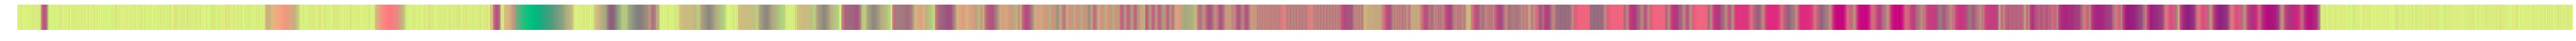

In [205]:
for rgb_img in rgb_imgs:
    fig, ax = plt.subplots(figsize=(fig_len,1))
    ax.imshow(rgb_img, interpolation=None, aspect='auto')
    ax.axis('off')

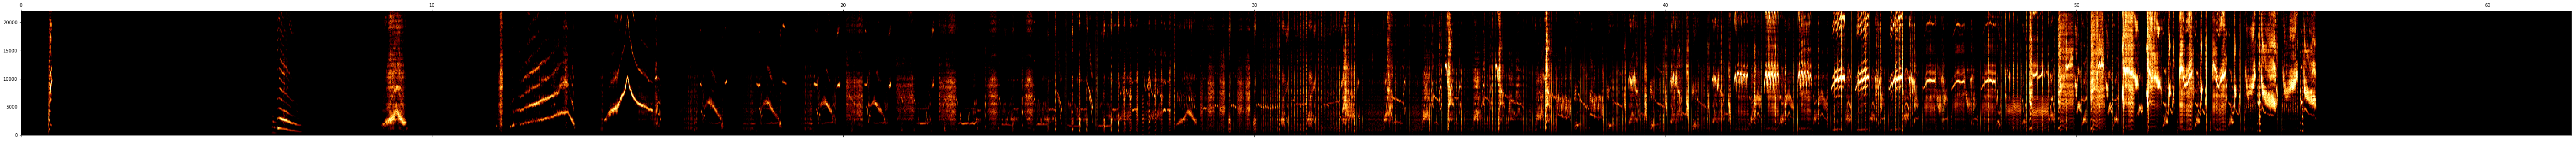

In [206]:
fig, ax = plt.subplots(figsize=(fig_len,5))
plot_spec(results['spec'], fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);

In [298]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [301]:
rgb_imgs = []
for axi, window_length_ms in enumerate(UMAP_dict):
    z = UMAP_dict[window_length_ms]
    
    # colormap
    H = norm(z[:,0])
    V = norm(z[:,1])
    S = np.ones_like(V)
    HSV = np.dstack((H,S,V))
    RGB = hsv_to_rgb(HSV)
    RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
    rgb_img = np.expand_dims(RGB,0)
    rgb_imgs.append(rgb_imgs)

In [ ]:
figsize = (50,5)
fig = plt.figure(figsize=figsize) 
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 10], wspace=0, hspace=0) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
for ax in [ax1, ax0]:
    ax.axis('off')
    
plot_spec(results['spec'], fig, ax3, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);

for rgb_img, ax in zip(rgb_imgs, [ax0, ax1, ax2]):
    ax.imshow(rgb_img, interpolation=None, aspect='auto')

In [268]:
H = norm(z[:,0])
V = norm(z[:,1])
S = np.ones_like(V)
HSV = np.dstack((H,S,V))
np.shape(HSV)

(1, 32931, 3)

In [269]:
RGB = hsv_to_rgb(HSV)
RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]

In [270]:
np.shape(cols)

(32931, 3)

In [271]:
cols[:3]

[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0]]

In [272]:
RGB[:3]

[[0.0, 0.22476499, 0.06407637],
 [0.0, 0.24229309, 0.093845546],
 [0.0, 0.24518083, 0.119440705]]

(-14.339621870663004,
 13.771712629940346,
 -12.231931086793555,
 15.598137255921971)

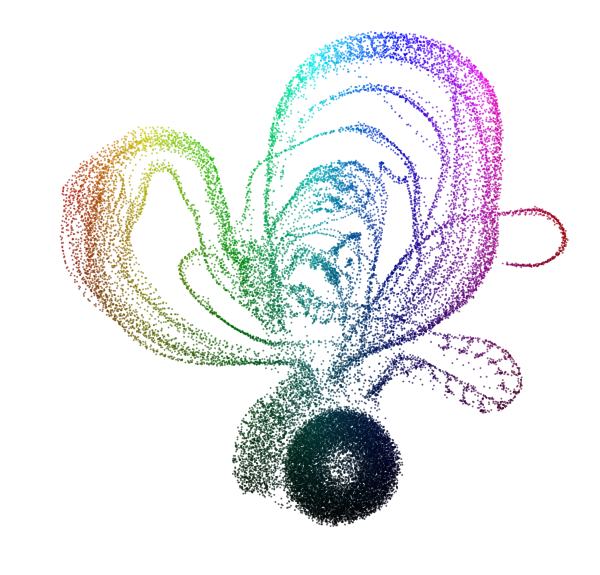

In [289]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(z[:,0], z[:,1], alpha = 0.5, s = 1, c=list(RGB))
ax.axis('off')

In [283]:
np.shape(np.expand_dims(RGB,0))

(32931, 1, 3)

In [278]:
rgb_img = np.expand_dims(RGB,1)

In [286]:
from matplotlib import gridspec

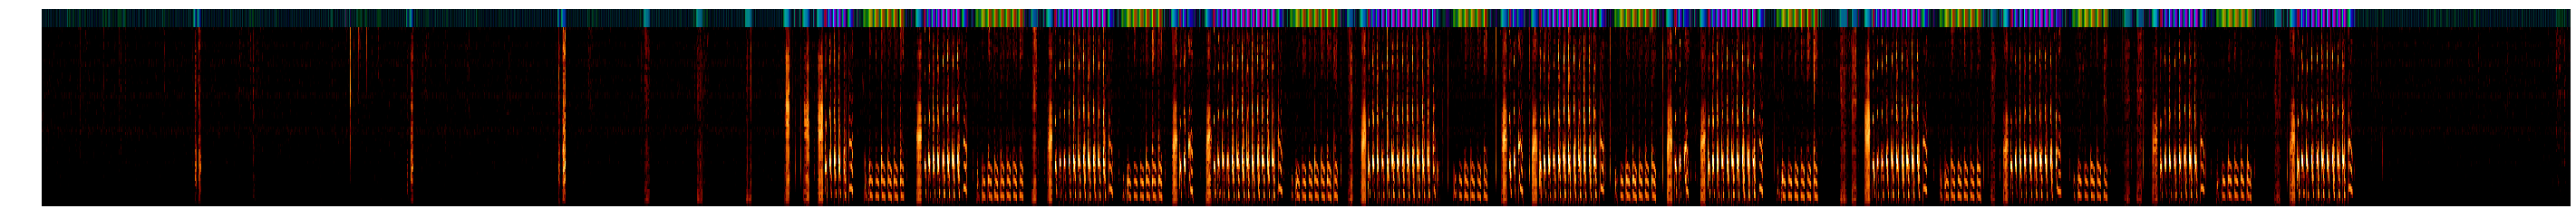

In [288]:
figsize = (100,4)
fig = plt.figure(figsize=figsize) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 10], wspace=0, hspace=0) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
for ax in [ax1, ax0]:
    ax.axis('off')
plot_spec(results['spec'], fig, ax1, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
ax0.imshow(np.expand_dims(RGB,0), interpolation=None, aspect='auto')
#axs[1].plot(z[:,0])
#axs[1].plot(z[:,1])
#axs[1].set_xlim([0, len(z)])

In [187]:
from sklearn.decomposition import IncrementalPCA

In [188]:
ipca = IncrementalPCA(n_components=2, batch_size=3)

In [189]:
ipca.fit(windows)

IncrementalPCA(batch_size=3, copy=True, n_components=2, whiten=False)

In [190]:
pcs = ipca.transform(windows) 

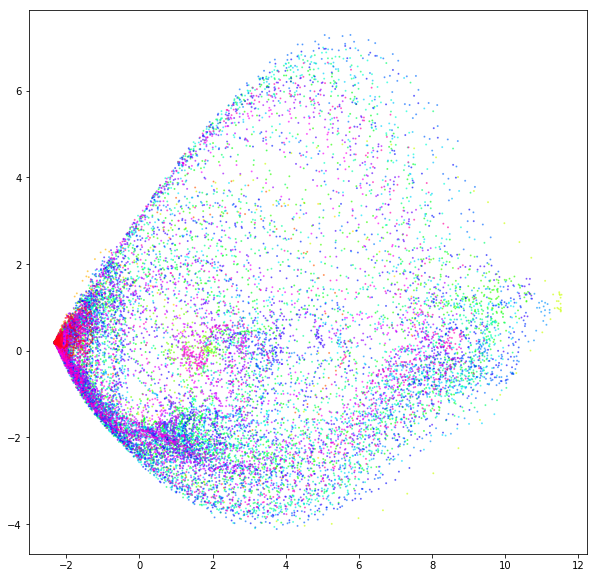

In [191]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(pcs[:,0], pcs[:,1], alpha = 0.5, s = 1, color=cols)